# 1. Build an image segmentation model using pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BirdSoundSegmentationModel(nn.Module):
    def __init__(self):
        super(BirdSoundSegmentationModel, self).__init__()
        # Encoder
        self.enc1 = self.conv_block(1, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128, 256)
        
        # Bottleneck
        self.bottleneck = self.conv_block(256, 512, dropout=True)
        
        # Decoder
        self.dec4 = self.upconv_block(512 + 256, 256)
        self.dec3 = self.upconv_block(256 + 128, 128)
        self.dec2 = self.upconv_block(128 + 64, 64)
        self.dec1 = self.upconv_block(64 + 32, 32)
        
        # Output layer
        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels, dropout=False):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        ]
        if dropout:
            layers.append(nn.Dropout(0.3))
        layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)  # (1, 32, H, W)
        enc2 = self.enc2(enc1)  # (32, 64, H/2, W/2)
        enc3 = self.enc3(enc2)  # (64, 128, H/4, W/4)
        enc4 = self.enc4(enc3)  # (128, 256, H/8, W/8)

        # Bottleneck
        bottleneck = self.bottleneck(enc4)  # (256, 512, H/16, W/16)

        # Decoder
        dec4 = self.dec4(torch.cat([F.interpolate(bottleneck, enc4.shape[2:], mode='bilinear', align_corners=False), enc4], dim=1))
        dec3 = self.dec3(torch.cat([F.interpolate(dec4, enc3.shape[2:], mode='bilinear', align_corners=False), enc3], dim=1))
        dec2 = self.dec2(torch.cat([F.interpolate(dec3, enc2.shape[2:], mode='bilinear', align_corners=False), enc2], dim=1))
        dec1 = self.dec1(torch.cat([F.interpolate(dec2, enc1.shape[2:], mode='bilinear', align_corners=False), enc1], dim=1))

        # Final segmentation map
        return torch.sigmoid(self.final_conv(dec1))


In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

class BirdSoundDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_size=(128, 128)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_size = target_size
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        image = image.resize(self.target_size, Image.Resampling.BILINEAR)
        mask = mask.resize(self.target_size, Image.Resampling.NEAREST)

        image = np.array(image, dtype=np.float32) / 255.0
        mask = np.array(mask, dtype=np.float32) / 255.0

        if self.transform:
            image = self.transform(Image.fromarray((image * 255).astype(np.uint8)))

        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        return image, mask

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Paths
train_dataset = BirdSoundDataset("/kaggle/input/birdies/Bird_Sound_Dataset/new_dataset/new_dataset/train/images","/kaggle/input/birdies/Bird_Sound_Dataset/new_dataset/new_dataset/train/masks", transform)
val_dataset = BirdSoundDataset("/kaggle/input/birdies/Bird_Sound_Dataset/new_dataset/new_dataset/valid/images", "/kaggle/input/birdies/Bird_Sound_Dataset/new_dataset/new_dataset/valid/masks", transform)
test_dataset = BirdSoundDataset("/kaggle/input/birdies/Bird_Sound_Dataset/new_dataset/new_dataset/test/images", "/kaggle/input/birdies/Bird_Sound_Dataset/new_dataset/new_dataset/test/masks", transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# 2. Train your model using [Bird sound datasets](https://yuad-my.sharepoint.com/personal/youshan_zhang_yu_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fyoushan%5Fzhang%5Fyu%5Fedu%2FDocuments%2FBird%5FSound%5FDataset&ga=1)

In [16]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Loss function
criterion = nn.BCELoss()

# Optimizer
model = BirdSoundSegmentationModel().cuda()
optimizer = Adam(model.parameters(), lr=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=40):
    best_loss = float('inf')
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images, masks = images.cuda(), masks.cuda()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.cuda(), masks.cuda()
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save the best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("New best model saved.")


In [17]:
def compute_iou(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = (preds + targets - preds * targets).sum(dim=(1, 2, 3))
    iou = (intersection / (union + 1e-6)).mean().item()
    return iou

def evaluate_model(model, test_loader):
    model.eval()
    total_iou = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)
            iou = compute_iou(outputs, masks)
            total_iou += iou

    mean_iou = total_iou / len(test_loader)
    print(f"Mean IoU: {mean_iou:.4f}")


In [18]:
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)


Epoch 1/40, Train Loss: 0.2576, Val Loss: 0.1253
New best model saved.
Epoch 2/40, Train Loss: 0.0970, Val Loss: 0.0958
New best model saved.
Epoch 3/40, Train Loss: 0.0917, Val Loss: 0.0915
New best model saved.
Epoch 4/40, Train Loss: 0.0883, Val Loss: 0.0793
New best model saved.
Epoch 5/40, Train Loss: 0.0823, Val Loss: 0.0848
Epoch 6/40, Train Loss: 0.0805, Val Loss: 0.0733
New best model saved.
Epoch 7/40, Train Loss: 0.0794, Val Loss: 0.0785
Epoch 8/40, Train Loss: 0.0784, Val Loss: 0.0743
Epoch 9/40, Train Loss: 0.0790, Val Loss: 0.0698
New best model saved.
Epoch 10/40, Train Loss: 0.0757, Val Loss: 0.0842
Epoch 11/40, Train Loss: 0.0772, Val Loss: 0.0695
New best model saved.
Epoch 12/40, Train Loss: 0.0730, Val Loss: 0.0721
Epoch 13/40, Train Loss: 0.0738, Val Loss: 0.0719
Epoch 14/40, Train Loss: 0.0736, Val Loss: 0.0712
Epoch 15/40, Train Loss: 0.0708, Val Loss: 0.0697
Epoch 16/40, Train Loss: 0.0681, Val Loss: 0.0727
Epoch 17/40, Train Loss: 0.0696, Val Loss: 0.0737
Epoch

# 3.Evaluate your model using the test images

In [9]:
# Load the best saved model
model = BirdSoundSegmentationModel().cuda()  
model.load_state_dict(torch.load('best_model.pth'))  # Load the best model weights

# Evaluate the model on the test dataset
evaluate_model(model, test_loader)



/tmp/ipykernel_185/2024529049.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))  # Load the best model weights


Mean IoU: 0.6324


# 4. Your IoU score should be higher than 60

In [7]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, num_samples=5, threshold=0.5):
    """
    Visualize predictions alongside ground truth masks.

    Args:
        model: Trained segmentation model.
        dataloader: DataLoader for the dataset to predict.
        num_samples: Number of samples to visualize.
        threshold: Threshold for binarizing predictions.

    Returns:
        None
    """
    model.eval()  # Set the model to evaluation mode

    images_shown = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)  
            
            preds = (outputs > threshold).float()  # Binarize predictions
            
            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    return
                
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                
                # Original image
                axs[0].imshow(images[i].squeeze().cpu().numpy(), cmap='gray')
                axs[0].set_title("Input Image")
                axs[0].axis('off')
                
                # Ground truth mask
                axs[1].imshow(masks[i].squeeze().cpu().numpy(), cmap='gray')
                axs[1].set_title("Ground Truth")
                axs[1].axis('off')
                
                # Predicted mask
                axs[2].imshow(preds[i].squeeze().cpu().numpy(), cmap='gray')
                axs[2].set_title("Prediction")
                axs[2].axis('off')
                
                plt.tight_layout()
                plt.show()
                
                images_shown += 1


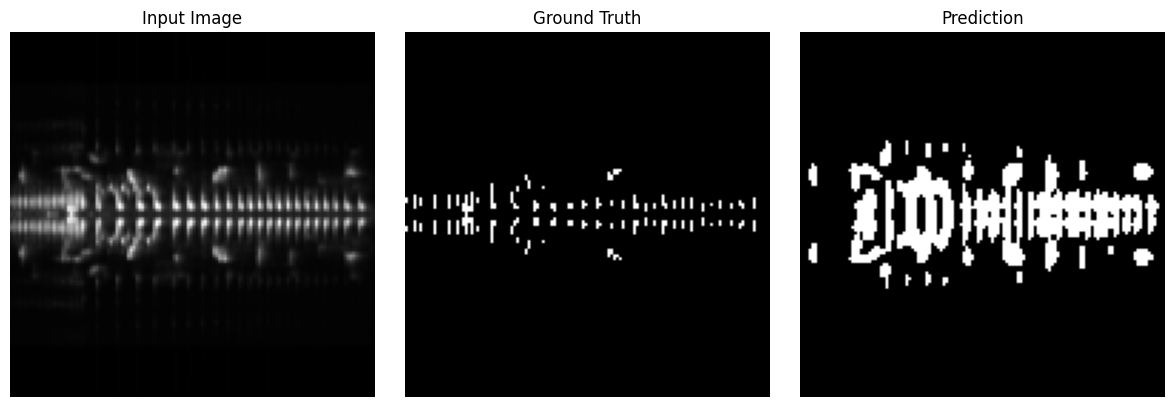

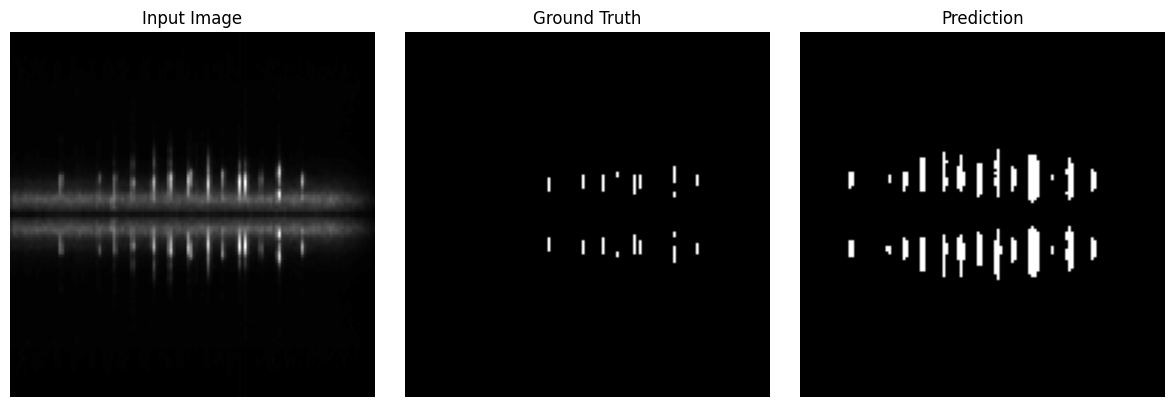

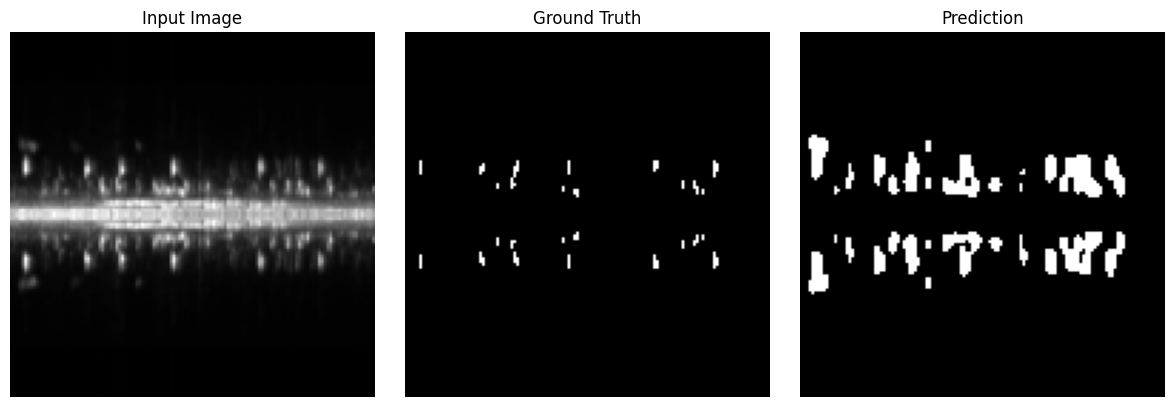

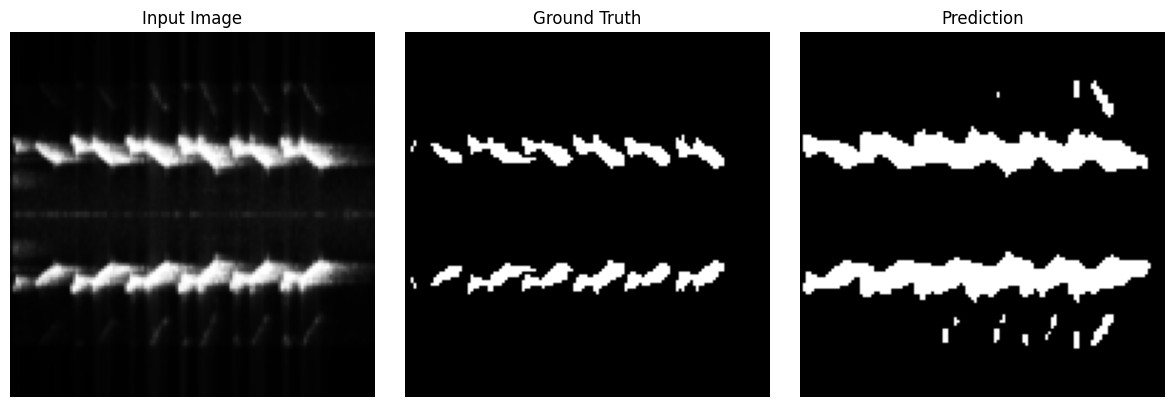

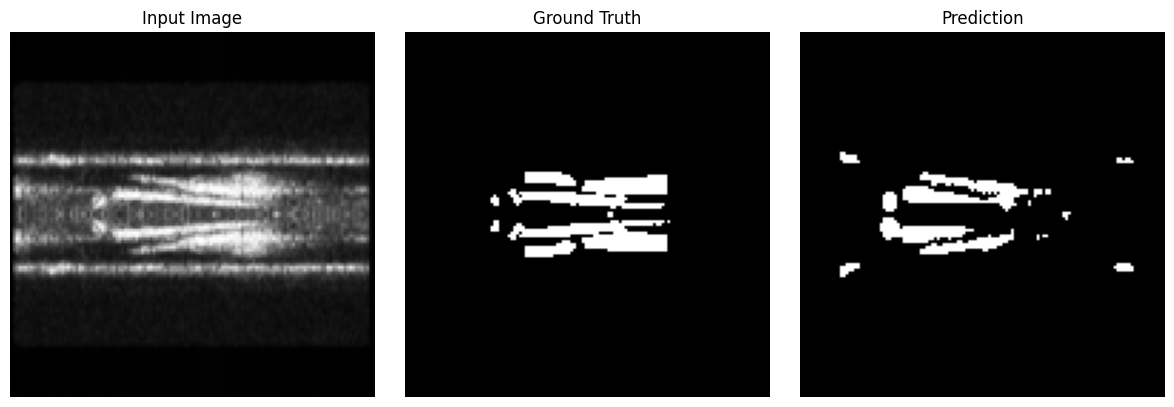

In [8]:
# Visualize predictions
visualize_predictions(model, test_loader, num_samples=5, threshold=0.5)


# 5. Write a 3-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 0.6 -->10 points
     < 0.5  --> 0 points
     >= 0.5 & < 0.6  --> 1 point/0.01 higher
     

(6). Discussion - 10 points